# Analyzing GRB 080916C
![Alt text](https://astrobites.org/wp-content/uploads/2014/10/NASAGRBwhoa-1024x576.jpg)
*(NASA/Swift/Cruz deWilde)*

To demonstrate the capabilities and features of 3ML in, we will go through a time-integrated and time-resolved analysis. This example serves as a standard way to analyze Fermi-GBM data with 3ML as well as a template for how you can design your instrument's analysis pipeline with 3ML if you have similar data.

3ML provides utilities to reduce time series data to plugins in a *correct* and *statistically justified* way (e.g., background fitting of Poisson data is done with a Poisson likelihood). The approach is generic and can be extended. For more details, see the [time series documentation](https://threeml.readthedocs.io/en/stable/notebooks/Building_Plugins_from_TimeSeries.html).

In [1]:
import warnings

warnings.simplefilter("ignore")

In [2]:
%%capture
import matplotlib.pyplot as plt
import numpy as np

np.seterr(all="ignore")


from threeML import *
from threeML.io.package_data import get_path_of_data_file

In [3]:

silence_warnings()
%matplotlib inline
from jupyterthemes import jtplot

jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
set_threeML_style()

## Examining the catalog

As with Swift and Fermi-LAT, 3ML provides a simple interface to the on-line Fermi-GBM catalog. Let's get the information for GRB 080916C.

In [4]:
gbm_catalog = FermiGBMBurstCatalog()
gbm_catalog.query_sources("GRB080916009")

00:54:25 INFO      The cache for fermigbrst does not yet exist. We will try to    ]8;id=378914;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=638283;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#64\64]8;;\
                  build it                                                                                         
                                                                                                                   

         INFO      Building cache for fermigbrst                                 ]8;id=47021;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py\get_heasarc_table_as_pandas.py]8;;\:]8;id=523261;file:///Users/runner/work/threeML/threeML/threeML/io/get_heasarc_table_as_pandas.py#112\112]8;;\

name,ra,dec,trigger_time,t90
object,float64,float64,float64,float64
GRB080916009,119.800,-56.600,54725.0088613,62.977


To aid in quickly replicating the catalog analysis, and thanks to the tireless efforts of the Fermi-GBM team, we have added the ability to extract the analysis parameters from the catalog as well as build an **astromodels** model with the best fit parameters baked in. Using this information, one can quickly run through the catalog an replicate the entire analysis with a script. Let's give it a try.

In [5]:
grb_info = gbm_catalog.get_detector_information()["GRB080916009"]

gbm_detectors = grb_info["detectors"]
source_interval = grb_info["source"]["fluence"]
background_interval = grb_info["background"]["full"]
best_fit_model = grb_info["best fit model"]["fluence"]
model = gbm_catalog.get_model(best_fit_model, "fluence")["GRB080916009"]

In [6]:
model

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (5):
--------------------

                                value min_value max_value            unit
GRB080916009...K             0.012255       0.0      None  keV-1 s-1 cm-2
GRB080916009...alpha        -1.130424      -1.5       2.0                
GRB080916009...break_energy  309.2031      10.0      None             keV
GRB080916009...break_scale        0.3       0.0      10.0                
GRB080916009...beta         -2.096931      -5.0      -1.6                

Fixed parameters (3):
(abridged. Use complete=True to see all fixed parameters)


Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

## Downloading the data
We provide a simple interface to download the Fermi-GBM data. Using the information from the catalog that we have extracted, we can download just the data from the detectors that were used for the catalog analysis. This will download the CSPEC, TTE and instrument response files from the on-line database.



In [7]:
dload = download_GBM_trigger_data("bn080916009", detectors=gbm_detectors)

Let's first examine the catalog fluence fit. Using the **TimeSeriesBuilder**, we can fit the background, set the source interval, and create a 3ML plugin for the analysis. We will loop through the detectors, set their appropriate channel selections, and ensure there are enough counts in each bin to make the [PGStat profile likelihood valid](https://giacomov.github.io/Bias-in-profile-poisson-likelihood/).

* First we use the CSPEC data to fit the background using the background selections. We use CSPEC because it has a longer duration for fitting the background.
* The background is saved to an HDF5 file that stores the polynomial coefficients and selections which we can read in to the TTE file later.
* The light curve is plotted.
* The source selection from the catalog is set and **DispersionSpectrumLike** plugin is created.
* The plugin has the standard GBM channel selections for spectral analysis set.

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

00:55:25 INFO      Auto-determined polynomial order: 0                                ]8;id=423002;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=829822;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_03 background:   0%|          | 0/128 [00:00<?, ?it/s]

00:55:48 INFO      None 0-order polynomial fit with the mle method                               ]8;id=115686;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=57884;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n3_bkg.h5                                         ]8;id=400950;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=538290;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n3_bkg.h5                                         ]8;id=544861;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=157578;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from n3_bkg.h5                              ]8;id=725968;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=368452;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

00:55:49 INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=877029;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=455599;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=972921;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=875565;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#485\485]8;;\

         INFO      - observation: poisson                                                       ]8;id=576632;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=538288;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#486\486]8;;\

         INFO      - background: gaussian                                                       ]8;id=895175;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=535232;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#487\487]8;;\

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=338145;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=220960;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

00:55:54 INFO      Now using 120 bins                                                          ]8;id=90548;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=203261;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

00:56:02 INFO      Auto-determined polynomial order: 1                                ]8;id=965939;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=211681;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_NAI_04 background:   0%|          | 0/128 [00:00<?, ?it/s]

00:56:29 INFO      None 1-order polynomial fit with the mle method                               ]8;id=337003;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=426303;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to n4_bkg.h5                                         ]8;id=125157;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=772213;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to n4_bkg.h5                                         ]8;id=5947;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=235180;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

00:56:30 INFO      Successfully restored fit from n4_bkg.h5                              ]8;id=582742;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=522050;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=888887;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=519516;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Auto-probed noise models:                                                    ]8;id=265895;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=648538;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#485\485]8;;\

         INFO      - observation: poisson                                                       ]8;id=233599;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=189341;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#486\486]8;;\

         INFO      - background: gaussian                                                       ]8;id=667432;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=30574;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#487\487]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=976770;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=337903;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=457969;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=251054;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

00:56:33 INFO      Auto-determined polynomial order: 1                                ]8;id=873132;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py\binned_spectrum_series.py]8;;\:]8;id=784703;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/binned_spectrum_series.py#389\389]8;;\

Fitting GBM_BGO_00 background:   0%|          | 0/128 [00:00<?, ?it/s]

00:56:58 INFO      None 1-order polynomial fit with the mle method                               ]8;id=211708;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=268281;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#458\458]8;;\

         INFO      Saved fitted background to b0_bkg.h5                                         ]8;id=103864;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py\time_series.py]8;;\:]8;id=309988;file:///Users/runner/work/threeML/threeML/threeML/utils/time_series/time_series.py#1064\1064]8;;\

         INFO      Saved background to b0_bkg.h5                                         ]8;id=634750;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=968937;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#471\471]8;;\

         INFO      Successfully restored fit from b0_bkg.h5                              ]8;id=752444;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=829112;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#171\171]8;;\

         INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=314510;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=35280;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

00:56:59 INFO      Auto-probed noise models:                                                    ]8;id=949737;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=171354;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#485\485]8;;\

         INFO      - observation: poisson                                                       ]8;id=711569;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=641733;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#486\486]8;;\

         INFO      - background: gaussian                                                       ]8;id=285773;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=293748;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#487\487]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=766133;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=626739;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=315160;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=485128;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

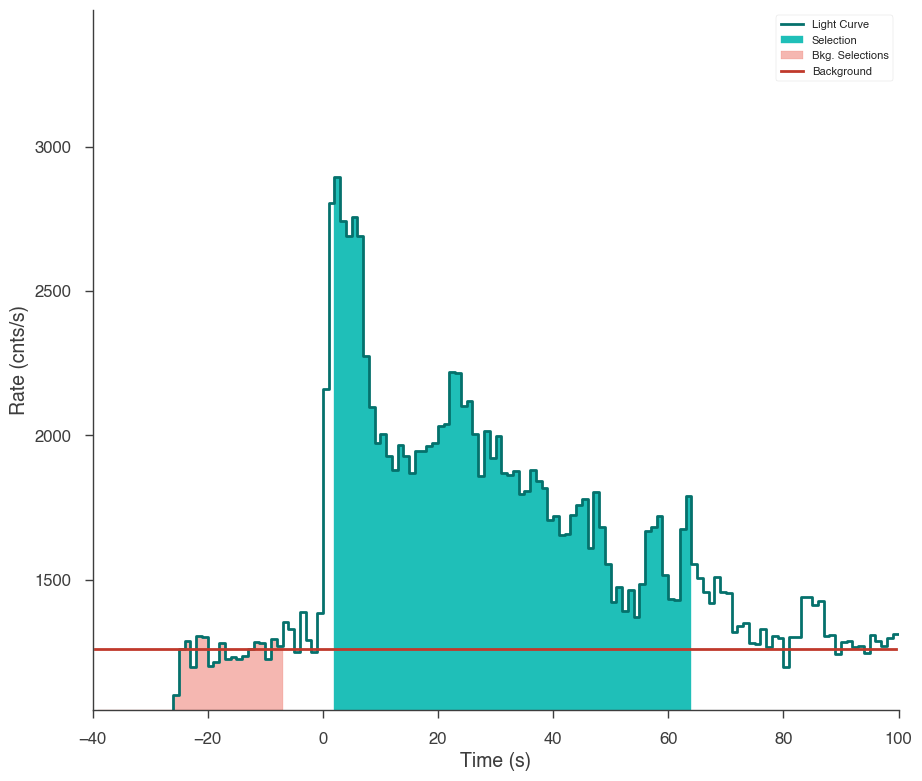

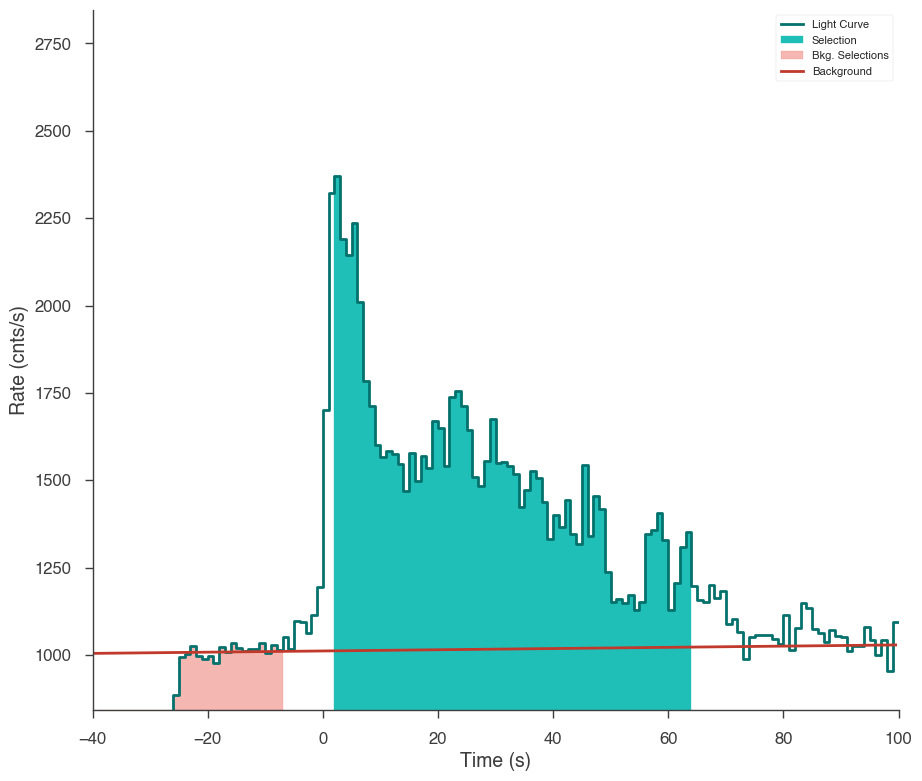

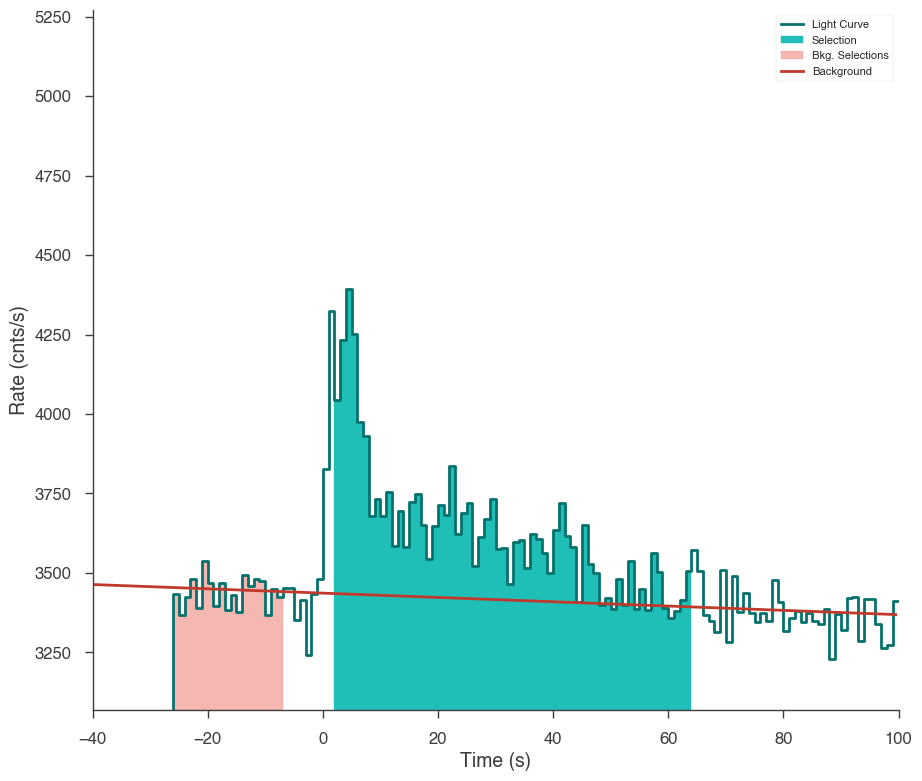

In [8]:
fluence_plugins = []
time_series = {}
for det in gbm_detectors:

    ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
        det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"]
    )

    ts_cspec.set_background_interval(*background_interval.split(","))
    ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

    ts_tte = TimeSeriesBuilder.from_gbm_tte(
        det,
        tte_file=dload[det]["tte"],
        rsp_file=dload[det]["rsp"],
        restore_background=f"{det}_bkg.h5",
    )

    time_series[det] = ts_tte

    ts_tte.set_active_time_interval(source_interval)

    ts_tte.view_lightcurve(-40, 100)

    fluence_plugin = ts_tte.to_spectrumlike()

    if det.startswith("b"):

        fluence_plugin.set_active_measurements("250-30000")

    else:

        fluence_plugin.set_active_measurements("9-900")

    fluence_plugin.rebin_on_background(1.0)

    fluence_plugins.append(fluence_plugin)

## Setting up the fit
Let's see if we can reproduce the results from the catalog.

### Set priors for the model
We will fit the spectrum using Bayesian analysis, so we must set priors on the model parameters.


In [9]:
model.GRB080916009.spectrum.main.shape.alpha.prior = Truncated_gaussian(
    lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.beta.prior = Truncated_gaussian(
    lower_bound=-5, upper_bound=-1.6, mu=-2.25, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.break_energy.prior = Log_normal(mu=2, sigma=1)
model.GRB080916009.spectrum.main.shape.break_energy.bounds = (None, None)
model.GRB080916009.spectrum.main.shape.K.prior = Log_uniform_prior(
    lower_bound=1e-3, upper_bound=1e1
)
model.GRB080916009.spectrum.main.shape.break_scale.prior = Log_uniform_prior(
    lower_bound=1e-4, upper_bound=10
)

### Clone the model and setup the Bayesian analysis class
Next, we clone the model we built from the catalog so that we can look at the results later and fit the cloned model. We pass this model and the **DataList** of the plugins to a **BayesianAnalysis** class and set the sampler to MultiNest.

In [10]:
new_model = clone_model(model)

bayes = BayesianAnalysis(new_model, DataList(*fluence_plugins))

# share spectrum gives a linear speed up when
# spectrumlike plugins have the same RSP input energies
bayes.set_sampler("multinest", share_spectrum=True)

00:57:00 INFO      sampler set to multinest                                                ]8;id=10952;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=159157;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

### Examine at the catalog fitted model
We can quickly examine how well the catalog fit matches the data. There appears to be a discrepancy between the data and the model! Let's refit to see if we can fix it.

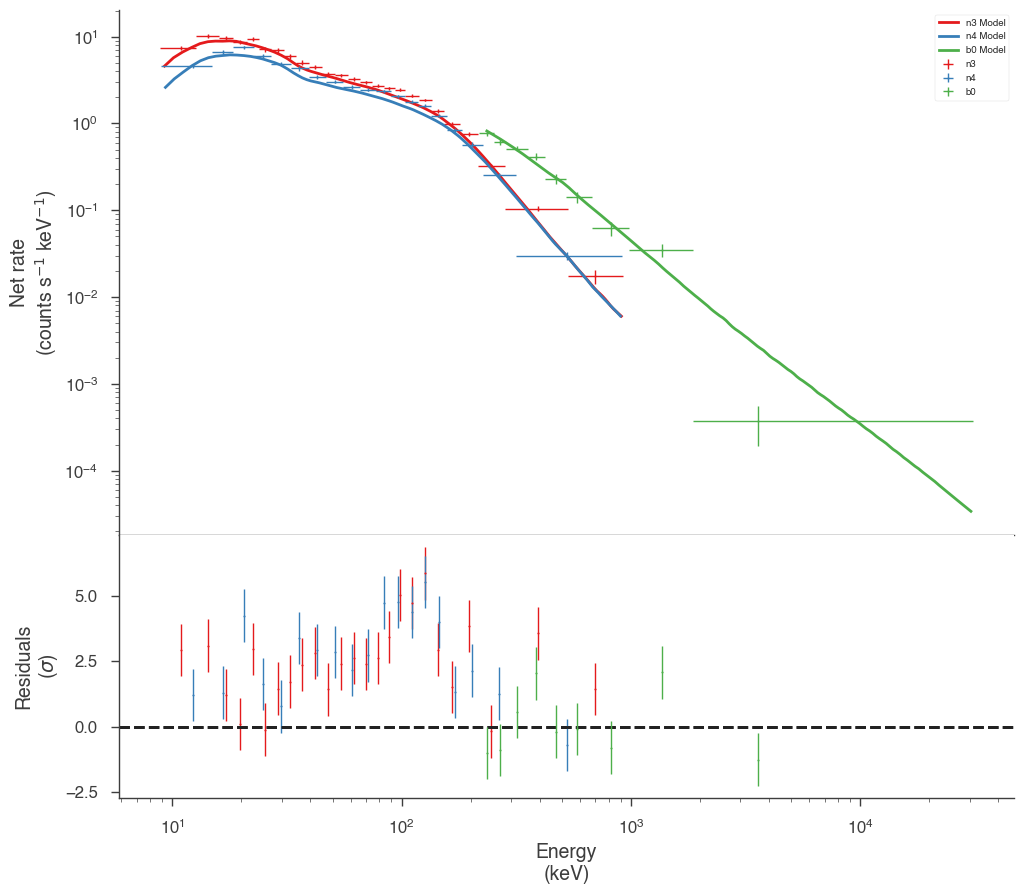

In [11]:
fig = display_spectrum_model_counts(bayes, min_rate=20, step=False)

### Run the sampler
We let MultiNest condition the model on the data

In [12]:
bayes.sampler.setup(n_live_points=400)
bayes.sample()

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    5
 *****************************************************


 ln(ev)=  -3108.0784703526847      +/-  0.24757364510077393     
 Total Likelihood Evaluations:        25312
  analysing data from chains/fit-.txt
 Sampling finished. Exiting MultiNest


00:57:33 INFO      fit restored to maximum of posterior                                         ]8;id=909266;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=166659;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=64612;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=564508;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
GRB080916009...K,(1.500 -0.017 +0.018) x 10^-2,1 / (cm2 keV s)
GRB080916009...alpha,-1.0597 -0.0010 +0.023,
GRB080916009...break_energy,(1.963 -0.13 -0.017) x 10^2,keV
GRB080916009...break_scale,(2.3 +/- 0.4) x 10^-1,
GRB080916009...beta,-2.016 +0.010 +0.07,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0,-1055.332463
n3,-1027.073753
n4,-1016.489257
total,-3098.895474


Values of statistical measures:

,statistical measures
AIC,6207.961402
BIC,6227.193612
DIC,6182.807512
PDIC,3.574391
log(Z),-1349.821329


Now our model seems to match much better with the data!

         INFO      fit restored to median of posterior                                          ]8;id=621660;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=545528;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

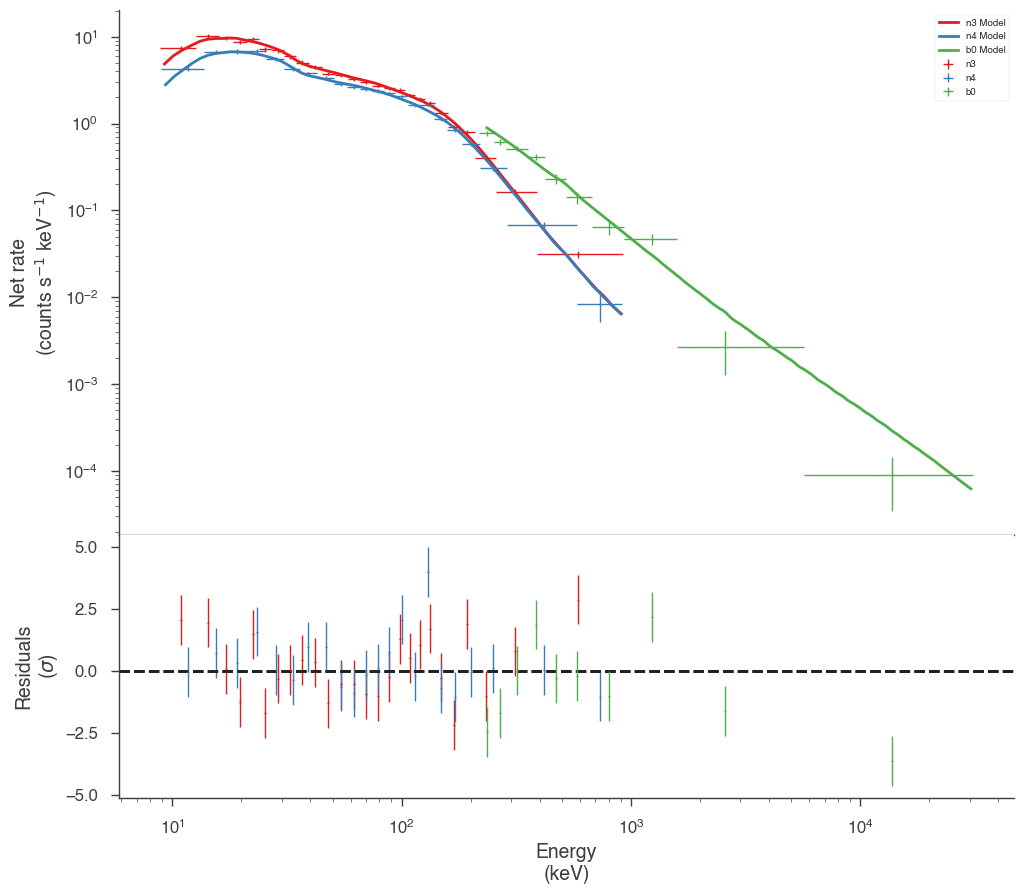

In [13]:
bayes.restore_median_fit()
fig = display_spectrum_model_counts(bayes, min_rate=20)

But how different are we from the catalog model? Let's plot our fit along with the catalog model. Luckily, 3ML can handle all the units for is

In [14]:
conversion = u.Unit("keV2/(cm2 s keV)").to("erg2/(cm2 s keV)")
energy_grid = np.logspace(1, 4, 100) * u.keV
vFv = (energy_grid**2 * model.get_point_source_fluxes(0, energy_grid)).to(
    "erg2/(cm2 s keV)"
)

processing Bayesian analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

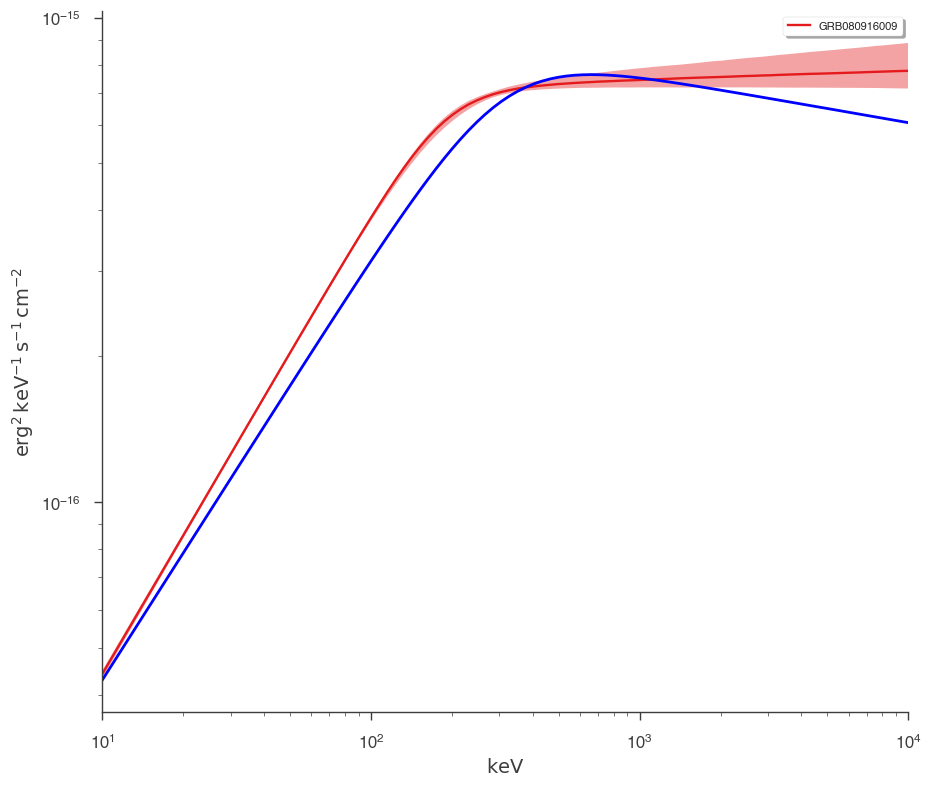

In [15]:
fig = plot_spectra(bayes.results, flux_unit="erg2/(cm2 s keV)")
ax = fig.get_axes()[0]
_ = ax.loglog(energy_grid, vFv, color="blue", label="catalog model")

## Time Resolved Analysis

Now that we have examined fluence fit, we can move to performing a time-resolved analysis.

### Selecting a temporal binning

We first get the brightest NaI detector and create time bins via the Bayesian blocks algorithm. We can use the fitted background to make sure that our intervals are chosen in an unbiased way.

In [16]:
n3 = time_series["n3"]

In [17]:
n3.create_time_bins(0, 60, method="bayesblocks", use_background=True, p0=0.2)

01:00:46 INFO      Created 15 bins via bayesblocks                                       ]8;id=808019;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=857502;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Sometimes, glitches in the GBM data cause spikes in the data that the Bayesian blocks algorithm detects as fast changes in the count rate. We will have to remove those intervals manually.

<div class="alert alert-info">

**Note:** In the future, 3ML will provide an automated method to remove these unwanted spikes.

</div>


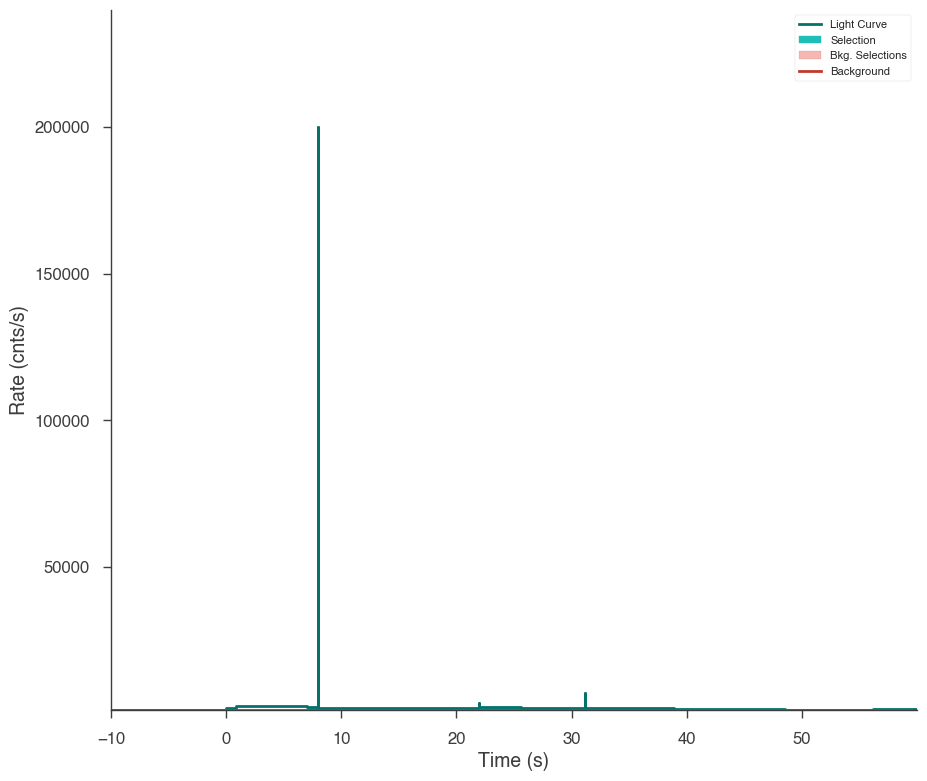

In [18]:
fig = n3.view_lightcurve(use_binner=True)

In [19]:
bad_bins = []
for i, w in enumerate(n3.bins.widths):

    if w < 5e-2:
        bad_bins.append(i)


edges = [n3.bins.starts[0]]

for i, b in enumerate(n3.bins):

    if i not in bad_bins:
        edges.append(b.stop)

starts = edges[:-1]
stops = edges[1:]


n3.create_time_bins(starts, stops, method="custom")

01:00:47 INFO      Created 12 bins via custom                                            ]8;id=958533;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=242302;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Now our light curve looks much more acceptable.

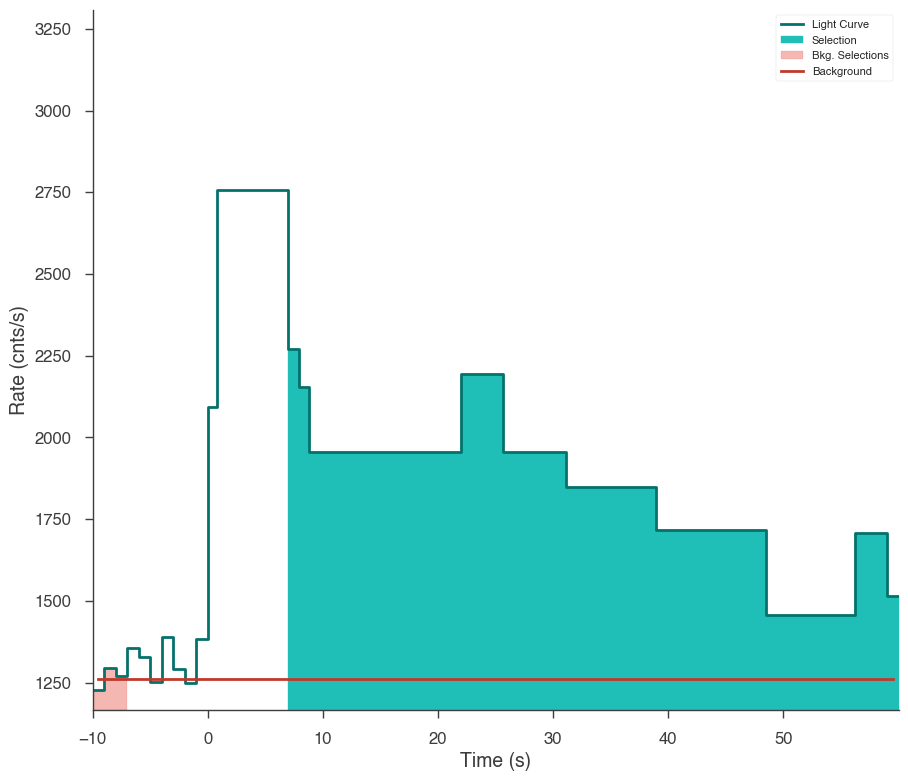

In [20]:
fig = n3.view_lightcurve(use_binner=True)

The time series objects can read time bins from each other, so we will map these time bins onto the other detectors' time series and create a list of time plugins for each detector and each time bin created above.

In [21]:
time_resolved_plugins = {}

for k, v in time_series.items():
    v.read_bins(n3)
    time_resolved_plugins[k] = v.to_spectrumlike(from_bins=True)

         INFO      Created 12 bins via custom                                            ]8;id=42216;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=893399;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

01:00:48 INFO      Interval set to 1.28-64.257 for n3                                    ]8;id=469600;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=30770;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Created 12 bins via custom                                            ]8;id=844380;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=454257;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

01:00:49 INFO      Interval set to 1.28-64.257 for n4                                    ]8;id=951902;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=789708;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

         INFO      Created 12 bins via custom                                            ]8;id=964021;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=161879;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#708\708]8;;\

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

01:00:50 INFO      Interval set to 1.28-64.257 for b0                                    ]8;id=914444;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py\time_series_builder.py]8;;\:]8;id=100122;file:///Users/runner/work/threeML/threeML/threeML/utils/data_builders/time_series_builder.py#290\290]8;;\

### Setting up the model
For the time-resolved analysis, we will fit the classic *Band* function to the data. We will set some principled priors.

In [22]:
band = Band()
band.alpha.prior = Truncated_gaussian(lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5)
band.beta.prior = Truncated_gaussian(lower_bound=-5, upper_bound=-1.6, mu=-2, sigma=0.5)
band.xp.prior = Log_normal(mu=2, sigma=1)
band.xp.bounds = (None, None)
band.K.prior = Log_uniform_prior(lower_bound=1e-10, upper_bound=1e3)
ps = PointSource("grb", 0, 0, spectral_shape=band)
band_model = Model(ps)

### Perform the fits

One way to perform Bayesian spectral fits to all the intervals is to loop through each one. There can are many ways to do this, so find an analysis pattern that works for you.



In [23]:
models = []
results = []
analysis = []
for interval in range(12):

    # clone the model above so that we have a separate model
    # for each fit

    this_model = clone_model(band_model)

    # for each detector set up the plugin
    # for this time interval

    this_data_list = []
    for k, v in time_resolved_plugins.items():

        pi = v[interval]

        if k.startswith("b"):
            pi.set_active_measurements("250-30000")
        else:
            pi.set_active_measurements("9-900")

        pi.rebin_on_background(1.0)

        this_data_list.append(pi)

    # create a data list

    dlist = DataList(*this_data_list)

    # set up the sampler and fit

    bayes = BayesianAnalysis(this_model, dlist)

    # get some speed with share spectrum
    bayes.set_sampler("multinest", share_spectrum=True)
    bayes.sampler.setup(n_live_points=500)
    bayes.sample()

    # at this stage we coudl also
    # save the analysis result to
    # disk but we will simply hold
    # onto them in memory

    analysis.append(bayes)

         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=384707;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=691314;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=433760;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=255826;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=622460;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=686928;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=429707;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=323712;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=337173;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=607046;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 107 bins                                                          ]8;id=524268;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=347441;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=798324;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=460723;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


 ln(ev)=  -789.33901362308450      +/-  0.17946669917564273     
 Total Likelihood Evaluations:        17778
 Sampling finished. Exiting MultiNest
  analysing data from chains/fit-.txt


01:01:12 INFO      fit restored to maximum of posterior                                         ]8;id=99383;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=506039;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=722860;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=421944;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(3.58 -0.07 +1.1) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-5.56 -0.22 +2.1) x 10^-1,
grb.spectrum.main.Band.xp,(3.12 -0.7 +0.14) x 10^2,keV
grb.spectrum.main.Band.beta,-2.04 -0.24 +0.10,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval0,-285.658957
n3_interval0,-250.117647
n4_interval0,-267.956909
total,-803.733513


Values of statistical measures:

,statistical measures
AIC,1615.580340
BIC,1630.989158
DIC,1570.176661
PDIC,2.278230
log(Z),-342.805578


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=389915;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=640072;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=74484;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=215107;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=578405;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=127776;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=670069;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=837995;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=451247;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=898194;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=430901;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=802300;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=898362;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=230760;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1981.9996174821331      +/-  0.23207545502688390     
 Total Likelihood Evaluations:        23390
 Sampling finished. Exiting MultiNest



01:01:40 INFO      fit restored to maximum of posterior                                         ]8;id=631869;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=543023;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=350254;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=312721;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(4.41 -0.09 +0.17) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.41 -0.09 +0.15) x 10^-1,
grb.spectrum.main.Band.xp,(4.66 -0.30 +0.22) x 10^2,keV
grb.spectrum.main.Band.beta,-1.7418 +0.0004 +0.009,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval1,-700.947069
n3_interval1,-645.998603
n4_interval1,-644.221810
total,-1991.167482


Values of statistical measures:

,statistical measures
AIC,3990.448279
BIC,4005.857097
DIC,3937.811595
PDIC,2.175203
log(Z),-860.771497


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=216090;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=998147;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=168466;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=101274;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=63613;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=678324;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=986331;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=11926;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=488709;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=892176;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 115 bins                                                          ]8;id=746055;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=422132;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=158978;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=719964;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -906.54631964400085      +/-  0.19403906372774030     
 Total Likelihood Evaluations:        20314
 Sampling finished. Exiting MultiNest



01:02:03 INFO      fit restored to maximum of posterior                                         ]8;id=315941;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=16526;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=799870;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=729644;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.53 -0.14 +0.26) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,-1.05 -0.05 +0.07,
grb.spectrum.main.Band.xp,(5.9 -1.3 +1.4) x 10^2,keV
grb.spectrum.main.Band.beta,-1.88 -0.13 +0.10,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval2,-324.481007
n3_interval2,-289.099155
n4_interval2,-312.399008
total,-925.979170


Values of statistical measures:

,statistical measures
AIC,1860.071655
BIC,1875.480473
DIC,1804.313560
PDIC,2.518889
log(Z),-393.708064


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=115602;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=239300;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=361402;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=285152;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=195611;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=564015;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=662791;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=572696;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=458947;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=809363;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 109 bins                                                          ]8;id=120067;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=734652;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=988066;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=984610;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -787.92473122039451      +/-  0.17492712180711417     
 Total Likelihood Evaluations:        17349
 Sampling finished. Exiting MultiNest



01:02:22 INFO      fit restored to maximum of posterior                                         ]8;id=157999;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=937638;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=800510;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=666877;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.82 -0.28 +0.5) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-9.4 -0.9 +1.1) x 10^-1,
grb.spectrum.main.Band.xp,(3.6 -0.7 +0.8) x 10^2,keV
grb.spectrum.main.Band.beta,-2.23 -0.5 +0.17,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval3,-298.550970
n3_interval3,-242.628391
n4_interval3,-262.723618
total,-803.902980


Values of statistical measures:

,statistical measures
AIC,1615.919274
BIC,1631.328092
DIC,1570.965896
PDIC,3.096192
log(Z),-342.191363


01:02:23 INFO      Range 9-900 translates to channels 5-124                                    ]8;id=16701;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=491615;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=971771;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=105567;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=719665;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=788505;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=480060;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=16707;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=160871;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=539451;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=564778;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=539069;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=933208;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=917263;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


 ln(ev)=  -2270.5866822494008      +/-  0.19766339405601449     
 Total Likelihood Evaluations:        20044
  analysing data from chains/fit-.txt
 Sampling finished. Exiting MultiNest


01:02:46 INFO      fit restored to maximum of posterior                                         ]8;id=905001;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=735845;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=178269;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=306609;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.04 +/- 0.11) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-9.9 +/- 0.4) x 10^-1,
grb.spectrum.main.Band.xp,(4.1 -0.4 +0.6) x 10^2,keV
grb.spectrum.main.Band.beta,-1.96 -0.14 +0.06,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval4,-778.604506
n3_interval4,-757.106872
n4_interval4,-746.823988
total,-2282.535366


Values of statistical measures:

,statistical measures
AIC,4573.184047
BIC,4588.592864
DIC,4527.913104
PDIC,3.438291
log(Z),-986.103267


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=540295;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=508950;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=336302;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=620758;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=438801;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=593759;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=760148;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=29662;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=534110;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=617465;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=909960;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=422743;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=842373;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=598001;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1576.4370846046024      +/-  0.20933712887828329     
 Total Likelihood Evaluations:        19710
 Sampling finished. Exiting MultiNest



01:03:09 INFO      fit restored to maximum of posterior                                         ]8;id=356192;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=2082;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=781223;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=781616;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.69 -0.16 +0.06) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-9.44 -0.5 +0.04) x 10^-1,
grb.spectrum.main.Band.xp,(4.62 -0.22 +0.7) x 10^2,keV
grb.spectrum.main.Band.beta,-2.350 -0.11 -0.019,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval5,-537.824240
n3_interval5,-523.533794
n4_interval5,-528.717530
total,-1590.075564


Values of statistical measures:

,statistical measures
AIC,3188.264443
BIC,3203.673261
DIC,3136.230703
PDIC,1.945445
log(Z),-684.637927


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=214282;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=13205;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=212964;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=599697;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=984128;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=431157;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=716542;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=28658;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=463733;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=575017;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=382889;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=51567;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=600544;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=199111;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1755.4568111847300      +/-  0.19290594806763445     
 Total Likelihood Evaluations:        19618
 Sampling finished. Exiting MultiNest



01:03:32 INFO      fit restored to maximum of posterior                                         ]8;id=459619;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=175394;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=782768;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=904952;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.95 -0.09 +0.15) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,-1.011 -0.035 +0.05,
grb.spectrum.main.Band.xp,(4.5 -0.7 +0.5) x 10^2,keV
grb.spectrum.main.Band.beta,-2.33 -0.31 +0.18,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval6,-609.571149
n3_interval6,-584.256399
n4_interval6,-576.821283
total,-1770.648831


Values of statistical measures:

,statistical measures
AIC,3549.410976
BIC,3564.819794
DIC,3500.692893
PDIC,3.157037
log(Z),-762.385206


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=673441;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=448822;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=829530;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=214677;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=318296;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=532991;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=272208;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=457430;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=339401;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=626449;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=929885;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=336389;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=982947;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=483126;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1939.9292201668695      +/-  0.19548825951239954     
 Total Likelihood Evaluations:        17916
 Sampling finished. Exiting MultiNest



01:03:54 INFO      fit restored to maximum of posterior                                         ]8;id=810480;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=240515;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=817918;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=940149;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.67 +/- 0.09) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,-1.04 +/- 0.04,
grb.spectrum.main.Band.xp,(4.3 -0.5 +0.6) x 10^2,keV
grb.spectrum.main.Band.beta,-2.27 -0.17 +0.13,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval7,-662.255577
n3_interval7,-640.979777
n4_interval7,-650.337645
total,-1953.572999


Values of statistical measures:

,statistical measures
AIC,3915.259313
BIC,3930.668130
DIC,3867.224893
PDIC,2.672308
log(Z),-842.500556


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=644761;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=347890;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=111923;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=60257;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=124815;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=515270;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=526315;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=584955;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=653540;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=503740;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=731781;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=213736;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=450159;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=876790;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -2055.0349500792545      +/-  0.19349976495588084     
 Total Likelihood Evaluations:        18477
 Sampling finished. Exiting MultiNest



01:04:15 INFO      fit restored to maximum of posterior                                         ]8;id=331135;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=853509;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=712094;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=720381;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.56 -0.15 +0.11) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.4 -0.8 +0.6) x 10^-1,
grb.spectrum.main.Band.xp,(3.7 -0.4 +0.7) x 10^2,keV
grb.spectrum.main.Band.beta,-2.33 -0.12 +0.11,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval8,-702.180834
n3_interval8,-698.619011
n4_interval8,-665.981114
total,-2066.780959


Values of statistical measures:

,statistical measures
AIC,4141.675233
BIC,4157.084051
DIC,4096.877880
PDIC,2.762623
log(Z),-892.490339


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=158117;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=269259;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=937712;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=488811;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=835464;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=187577;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=629465;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=770895;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=202;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=613788;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

01:04:16 INFO      Now using 119 bins                                                          ]8;id=363553;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=52938;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=690128;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=632759;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1879.0767714461213      +/-  0.14608530527688787     
 Total Likelihood Evaluations:        12622
 Sampling finished. Exiting MultiNest



01:04:31 INFO      fit restored to maximum of posterior                                         ]8;id=83912;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=644164;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=783063;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=699615;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.10 -0.14 +1.5) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.7 -0.7 +4) x 10^-1,
grb.spectrum.main.Band.xp,(1.10 -0.4 +0.21) x 10^2,keV
grb.spectrum.main.Band.beta,-1.84 -0.23 +0.12,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval9,-648.414077
n3_interval9,-616.865156
n4_interval9,-616.188805
total,-1881.468038


Values of statistical measures:

,statistical measures
AIC,3771.049391
BIC,3786.458209
DIC,3705.779547
PDIC,-41.015876
log(Z),-816.072673


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=302990;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=103958;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=862870;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=156218;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=718589;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=335547;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=327922;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=204867;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=214478;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=609201;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=619721;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=247358;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=566738;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=978630;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -1322.6124860501534      +/-  0.16800334342041379     
 Total Likelihood Evaluations:        15389
 Sampling finished. Exiting MultiNest



01:04:50 INFO      fit restored to maximum of posterior                                         ]8;id=53052;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=35683;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=164637;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=843827;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.13 -0.20 +0.7) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-7.2 -0.5 +1.8) x 10^-1,
grb.spectrum.main.Band.xp,(2.09 -0.5 +0.34) x 10^2,keV
grb.spectrum.main.Band.beta,-1.94 -0.4 +0.13,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval10,-460.709844
n3_interval10,-437.785466
n4_interval10,-432.960210
total,-1331.455520


Values of statistical measures:

,statistical measures
AIC,2671.024355
BIC,2686.433173
DIC,2634.926782
PDIC,1.135764
log(Z),-574.403304


         INFO      Range 9-900 translates to channels 5-124                                    ]8;id=720334;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=963763;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 120 bins                                                          ]8;id=278980;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=682937;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 9-900 translates to channels 5-123                                    ]8;id=368702;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=320278;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=777493;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=757032;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      Range 250-30000 translates to channels 1-119                                ]8;id=518119;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=42943;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1242\1242]8;;\

         INFO      Now using 119 bins                                                          ]8;id=72502;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py\SpectrumLike.py]8;;\:]8;id=945090;file:///Users/runner/work/threeML/threeML/threeML/plugins/SpectrumLike.py#1734\1734]8;;\

         INFO      sampler set to multinest                                                ]8;id=842773;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py\bayesian_analysis.py]8;;\:]8;id=154825;file:///Users/runner/work/threeML/threeML/threeML/bayesian/bayesian_analysis.py#197\197]8;;\

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************


  analysing data from chains/fit-.txt ln(ev)=  -812.36619853926879      +/-  0.14858187192389977     
 Total Likelihood Evaluations:        12601
 Sampling finished. Exiting MultiNest



01:05:28 INFO      fit restored to maximum of posterior                                         ]8;id=468099;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=221634;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

         INFO      fit restored to maximum of posterior                                         ]8;id=680505;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=553616;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#178\178]8;;\

Maximum a posteriori probability (MAP) point:

,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.8 -1.0 +1.8) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-4.6 -2.9 +2.2) x 10^-1,
grb.spectrum.main.Band.xp,(1.30 -0.31 +0.29) x 10^2,keV
grb.spectrum.main.Band.beta,-2.12 -0.18 +0.23,


Values of -log(posterior) at the minimum:

,-log(posterior)
b0_interval11,-292.451591
n3_interval11,-272.287179
n4_interval11,-256.050572
total,-820.789342


Values of statistical measures:

,statistical measures
AIC,1649.691999
BIC,1665.100816
DIC,1616.105119
PDIC,-0.623241
log(Z),-352.806157


### Examine the fits
Now we can look at the fits in count space to make sure they are ok.

01:05:29 INFO      fit restored to median of posterior                                          ]8;id=694143;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=120928;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

01:05:30 INFO      fit restored to median of posterior                                          ]8;id=669908;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=624100;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

01:05:31 INFO      fit restored to median of posterior                                          ]8;id=931326;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=425104;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

01:05:34 INFO      fit restored to median of posterior                                          ]8;id=357884;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=231462;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

01:05:35 INFO      fit restored to median of posterior                                          ]8;id=4127;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=707529;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

01:05:36 INFO      fit restored to median of posterior                                          ]8;id=803352;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=503217;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

01:05:37 INFO      fit restored to median of posterior                                          ]8;id=897404;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=580100;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

01:05:39 INFO      fit restored to median of posterior                                          ]8;id=601535;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=982127;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

01:05:40 INFO      fit restored to median of posterior                                          ]8;id=302768;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=701030;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

01:05:42 INFO      fit restored to median of posterior                                          ]8;id=304966;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=924608;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

01:05:43 INFO      fit restored to median of posterior                                          ]8;id=968185;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=458671;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

01:05:45 INFO      fit restored to median of posterior                                          ]8;id=631727;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py\sampler_base.py]8;;\:]8;id=233041;file:///Users/runner/work/threeML/threeML/threeML/bayesian/sampler_base.py#164\164]8;;\

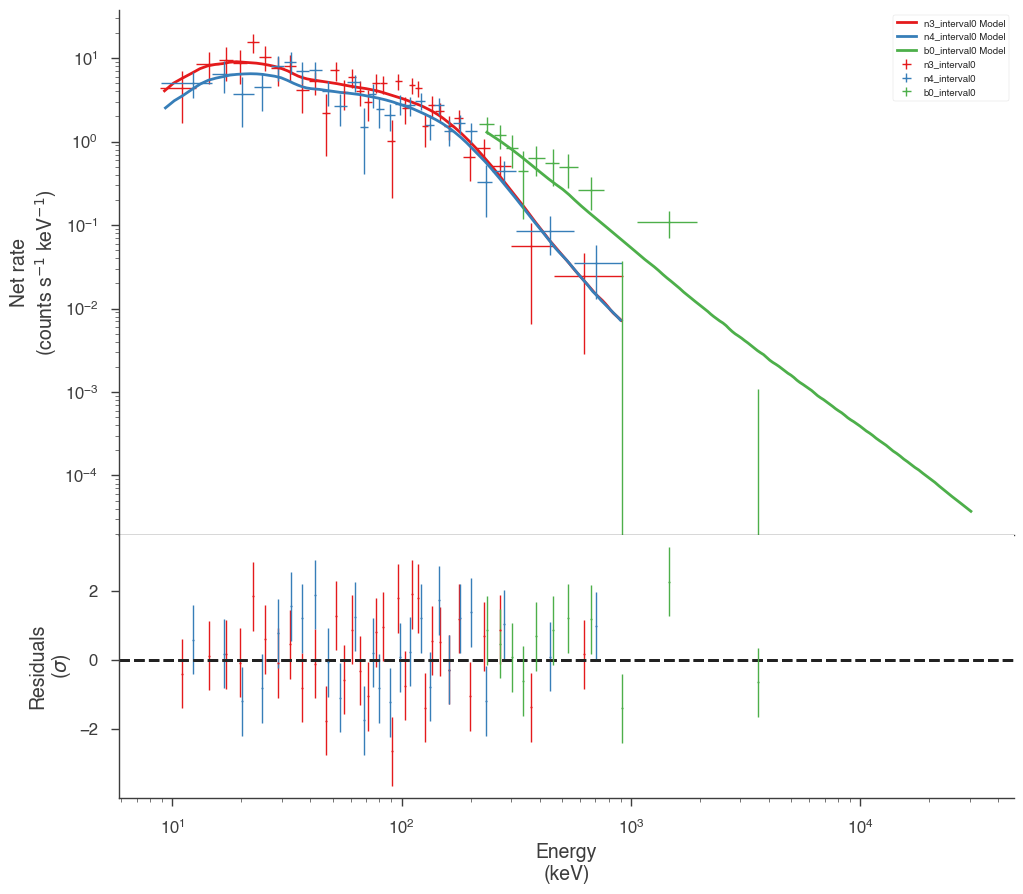

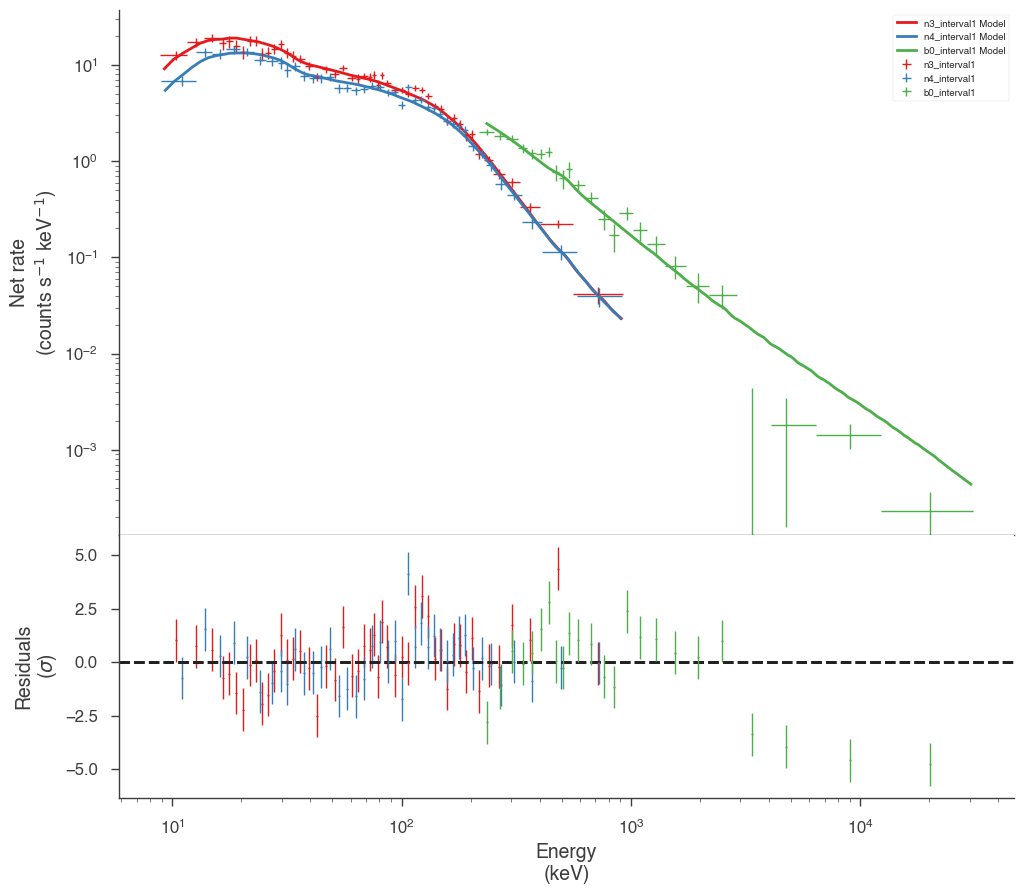

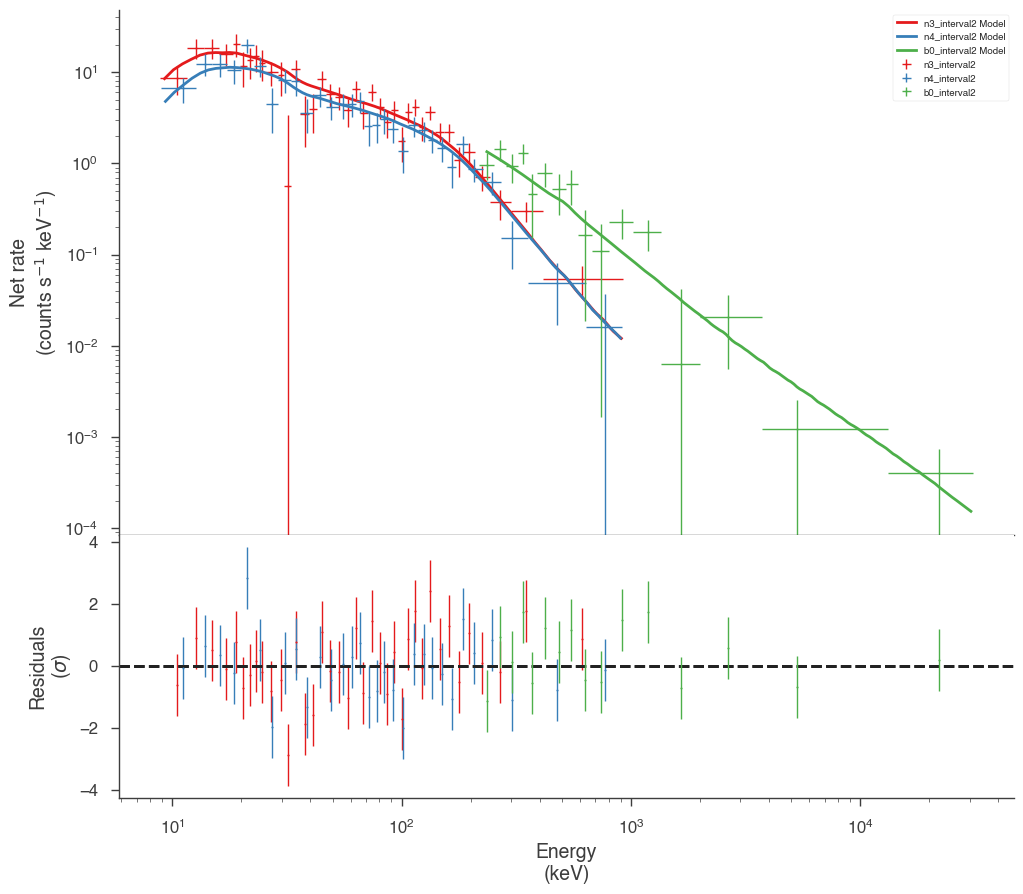

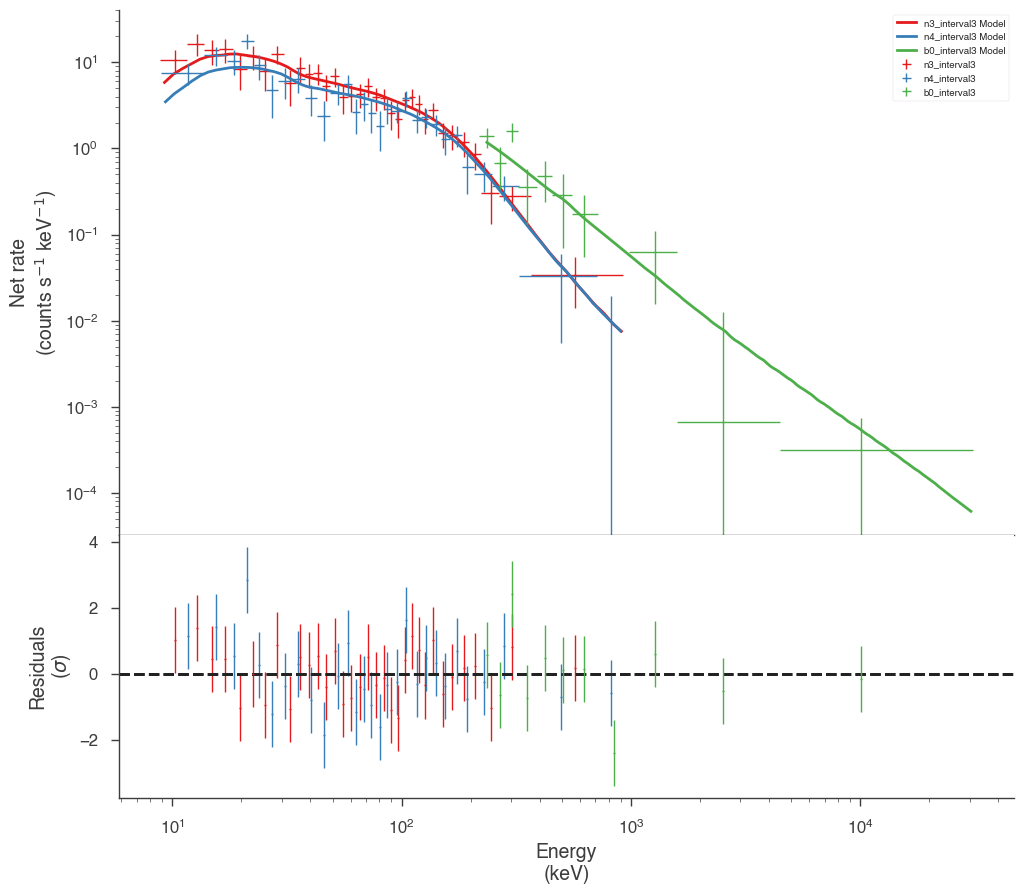

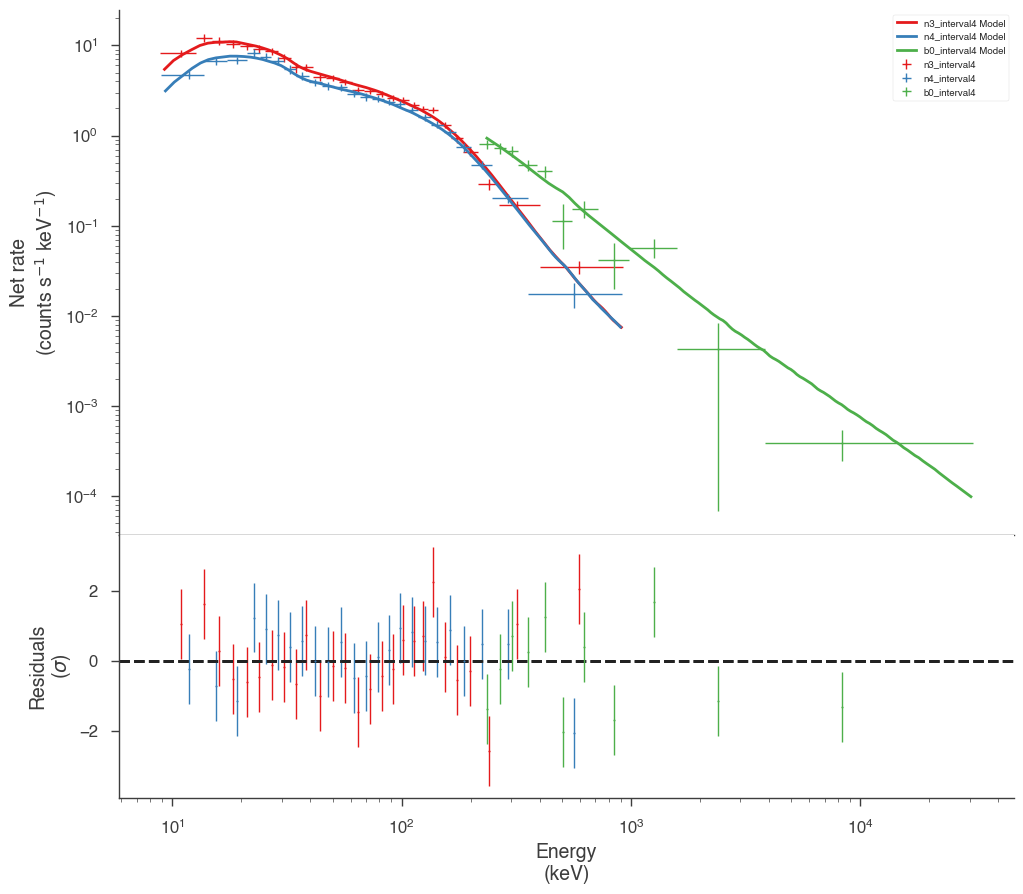

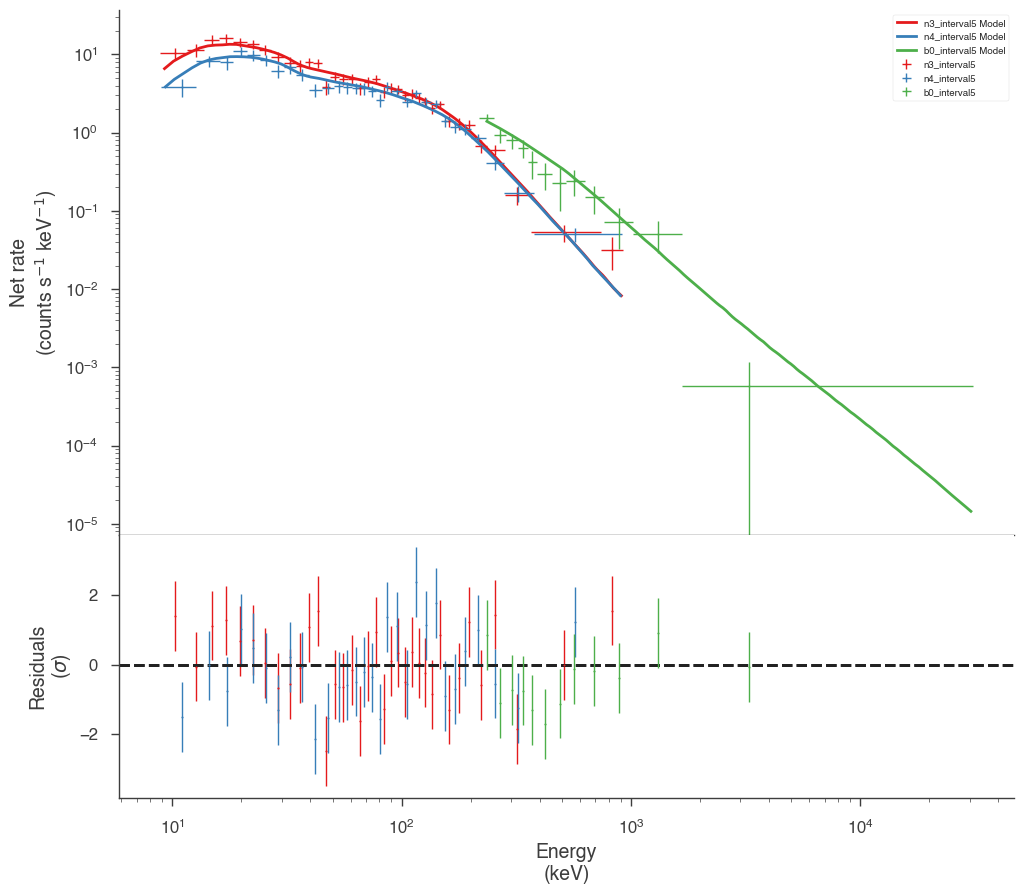

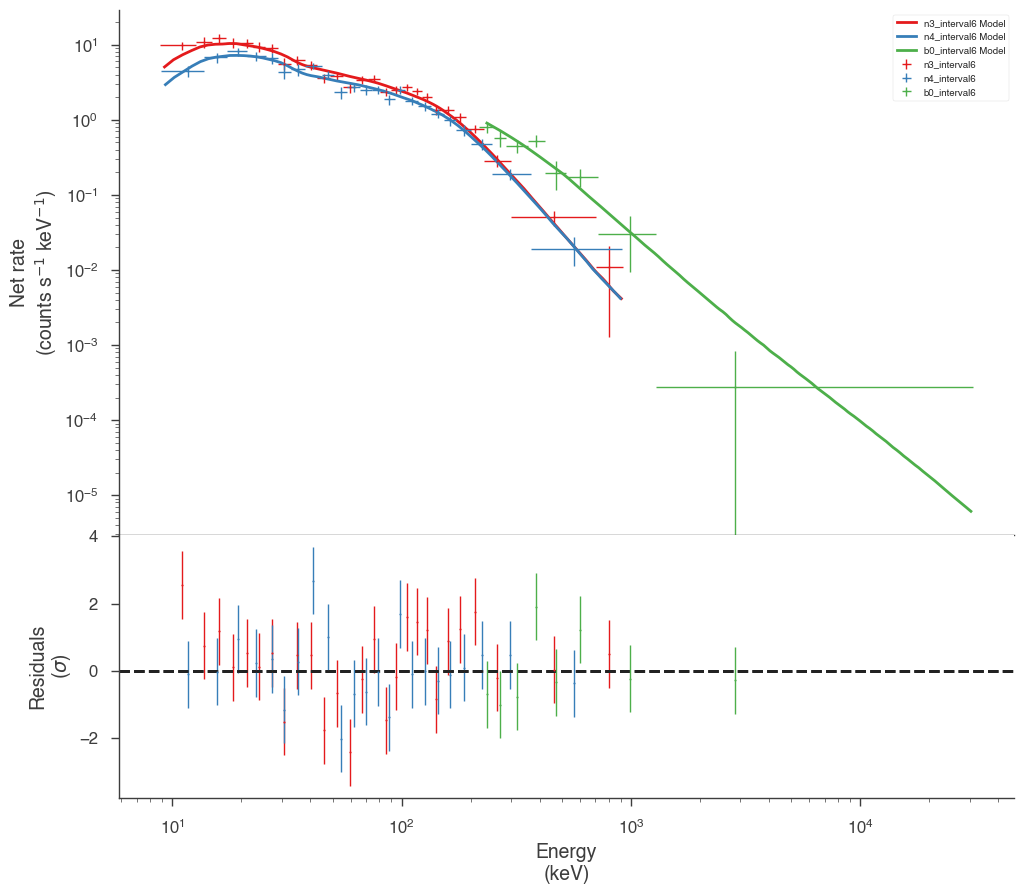

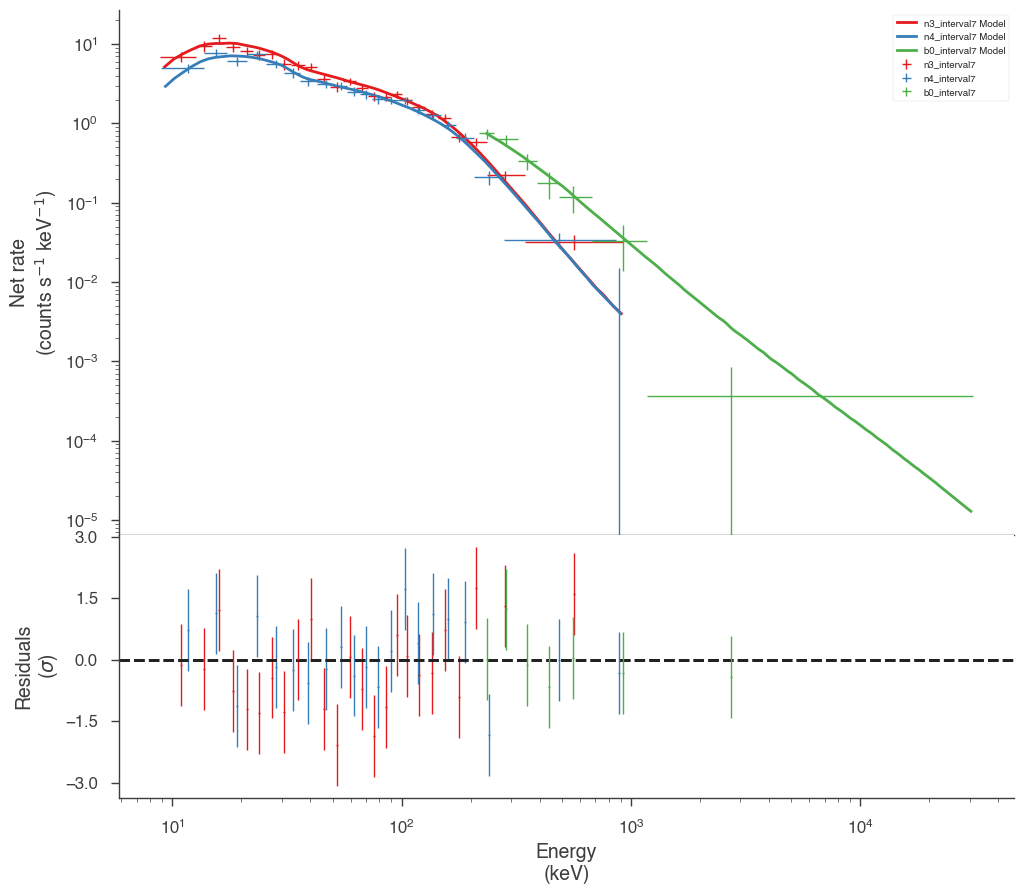

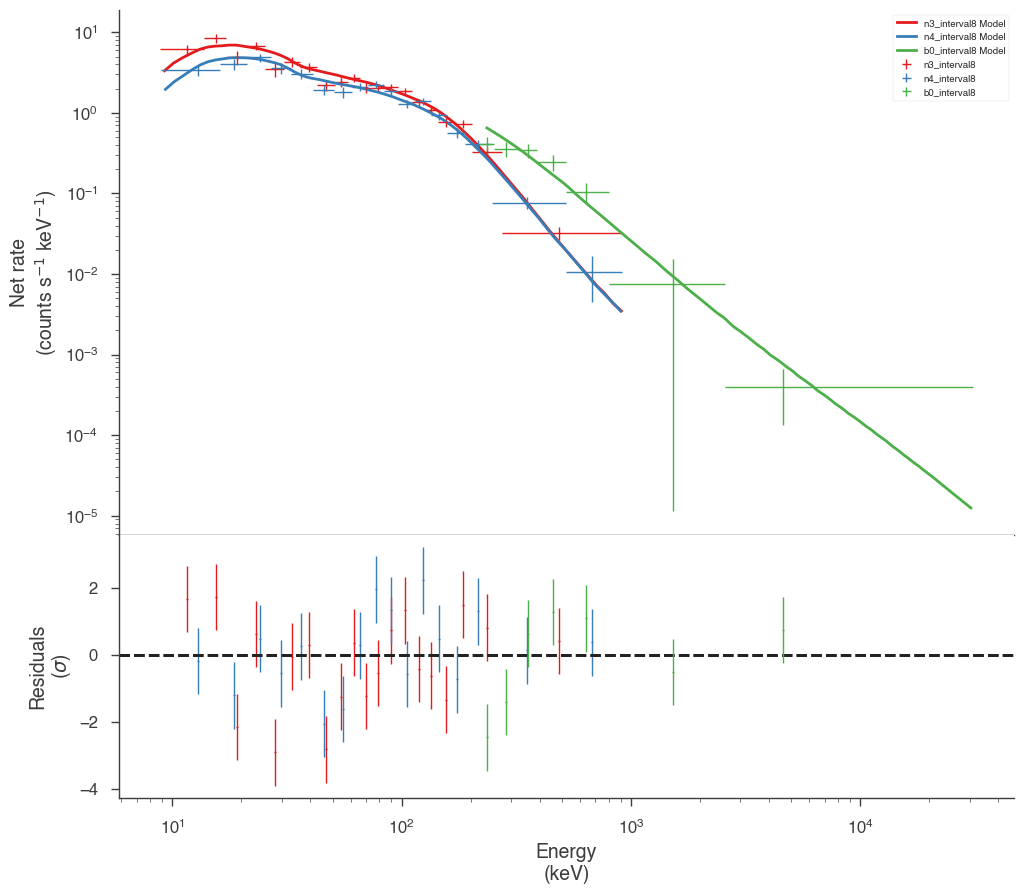

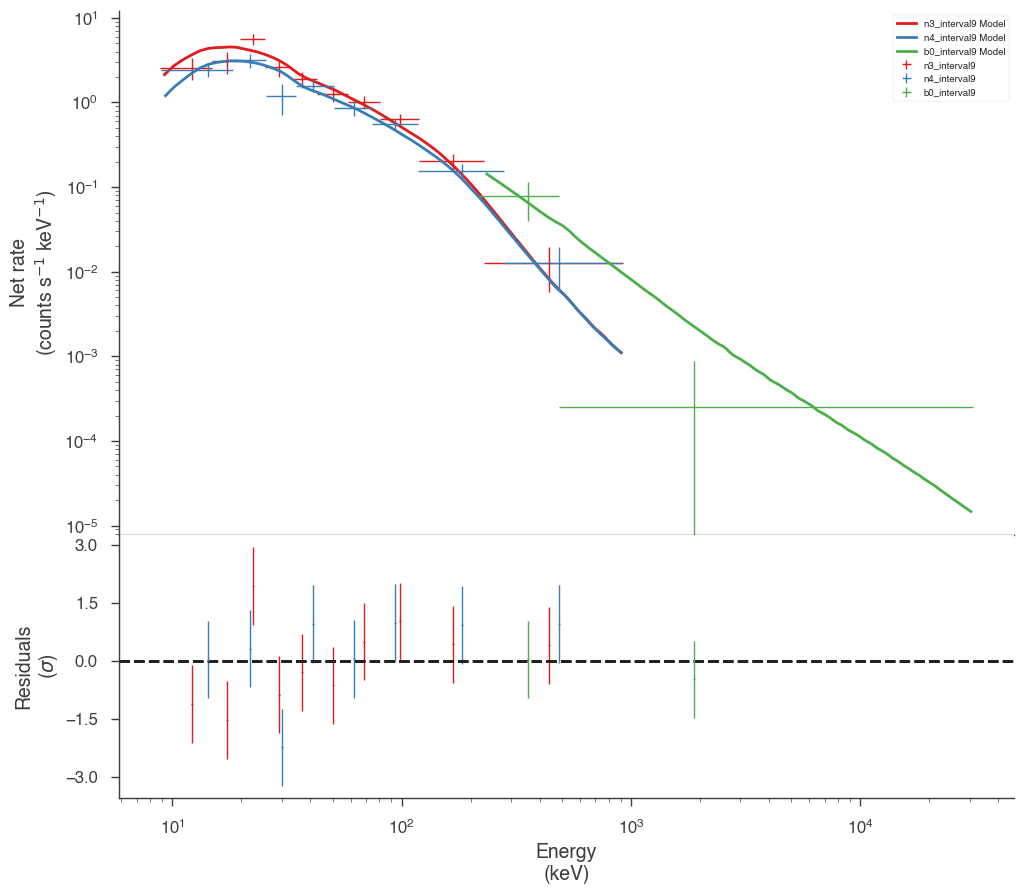

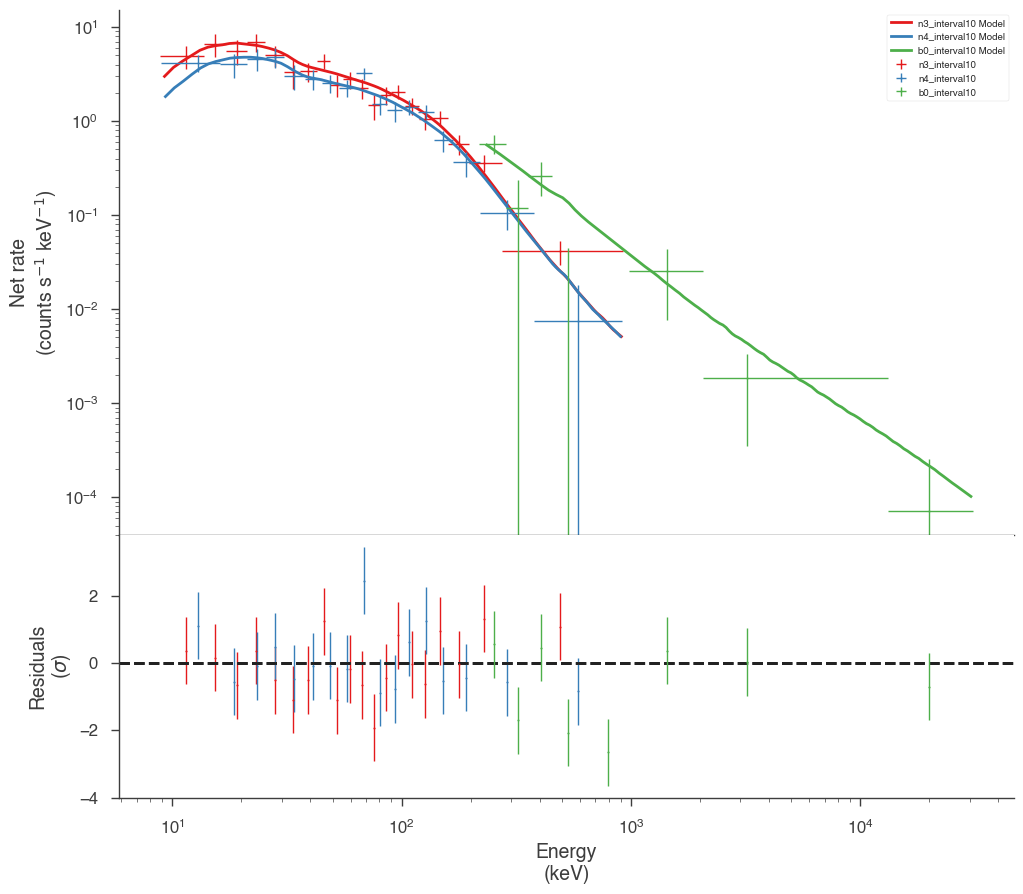

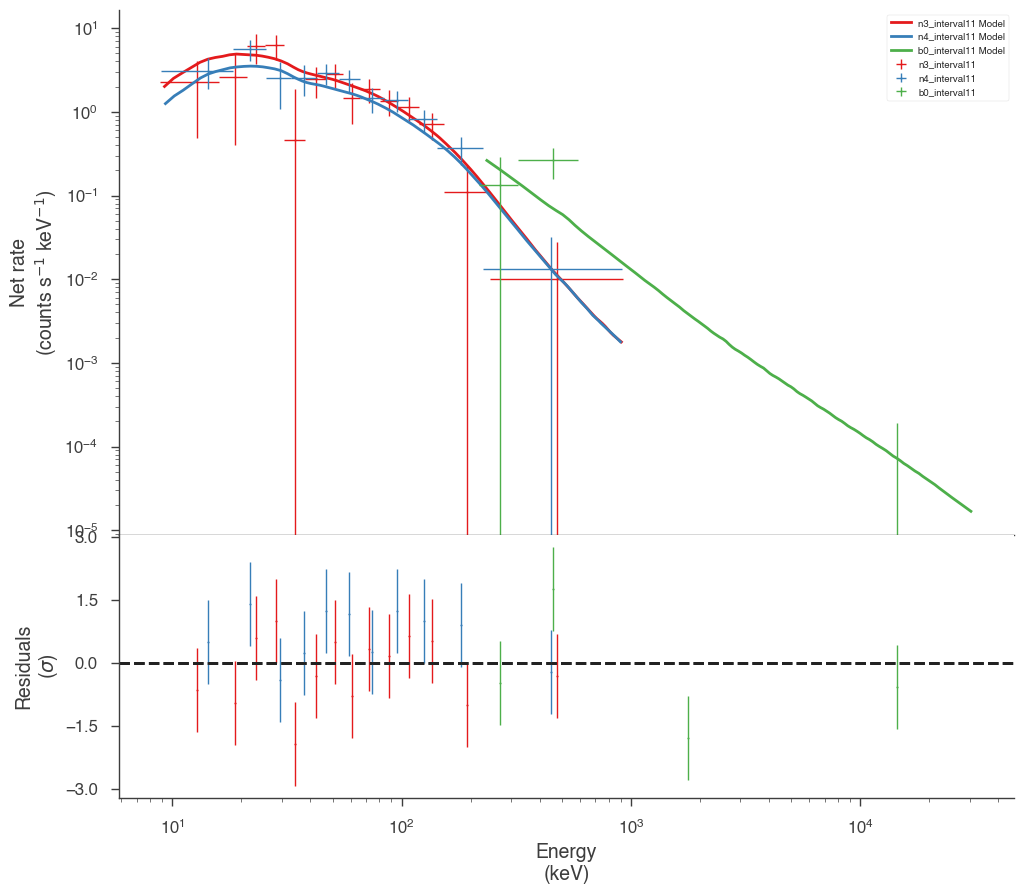

In [24]:
for a in analysis:
    a.restore_median_fit()
    _ = display_spectrum_model_counts(a, min_rate=[20, 20, 20], step=False)

Finally, we can plot the models together to see how the spectra evolve with time.

processing Bayesian analyses:   0%|          | 0/12 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

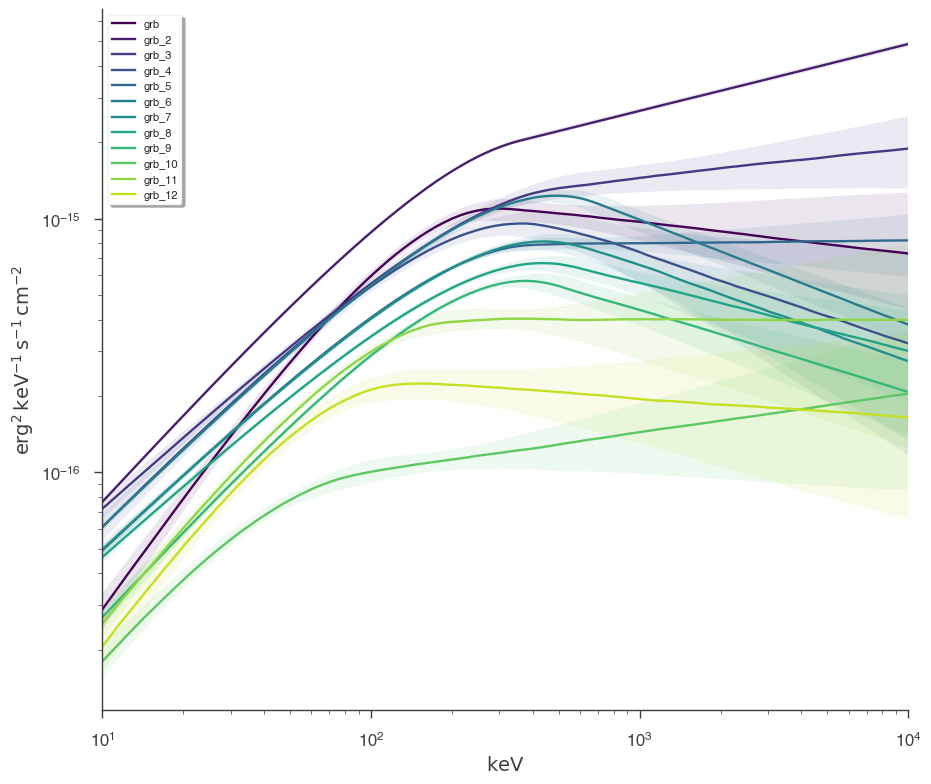

In [25]:
fig = plot_spectra(
    *[a.results for a in analysis[::1]],
    flux_unit="erg2/(cm2 s keV)",
    fit_cmap="viridis",
    contour_cmap="viridis",
    contour_style_kwargs=dict(alpha=0.1),
)

This example can serve as a template for performing analysis on GBM data. However, as 3ML provides an abstract interface and modular building blocks, similar analysis pipelines can be built for any time series data.